In [1]:
import os
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

2025-04-02 01:33:40.419376: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 01:33:40.427564: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 01:33:40.498195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 01:33:40.498250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 01:33:40.500327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Set the random seed for reproducibility
tf.random.set_seed(42)
# Set the seed
np.random.seed(42)


In [3]:
# Load cell count data
cell_counts = pd.read_csv("cellTypeCounts.for.scCODA_input.csv")

order = ["Control", "NTCU-treated"]

cell_counts["phenotype"] = pd.Categorical(cell_counts["phenotype"], categories = order, ordered = True)
cell_counts = cell_counts.sort_values(by = "phenotype")

print(cell_counts)

  patientID     phenotype  Basal proliferative  Basal  Basal Tgm2+  \
3    MD7179       Control                  124    503          919   
4    MD7219       Control                    7     57           35   
5    MR7352       Control                  247    769          850   
0    MD7176  NTCU-treated                  638    168          693   
1    MD7177  NTCU-treated                   98    262          860   
2    MD7178  NTCU-treated                   55    111          422   

   Basal Mecom+  Basal Krt14+  Krt4/13+  Secretory  Secretory Mecom+  \
3            76          1215       939       1800               161   
4             8            26        16         64                 8   
5            89          1176       833       1781               192   
0            65          1242      1866       1392               152   
1           120          1646      1560        678               115   
2            61          1270      1626        738               329   

   D

In [4]:
#convert into anndata
data_all = dat.from_pandas(cell_counts, 
                           covariate_columns=["patientID", "phenotype"])

print(data_all)

AnnData object with n_obs × n_vars = 6 × 13
    obs: 'patientID', 'phenotype'


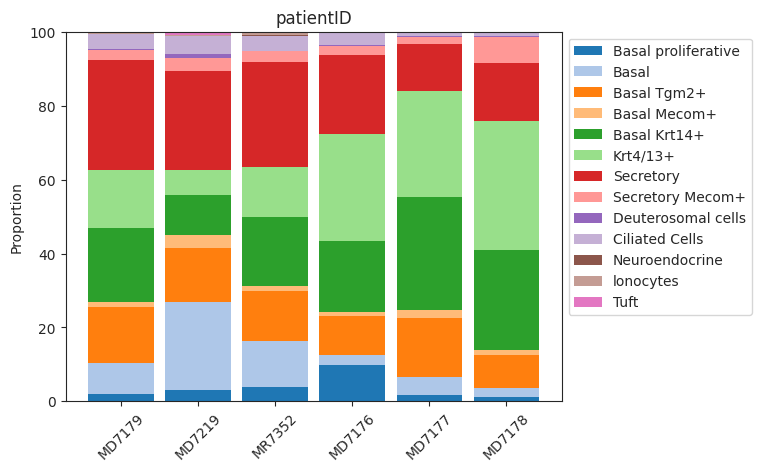

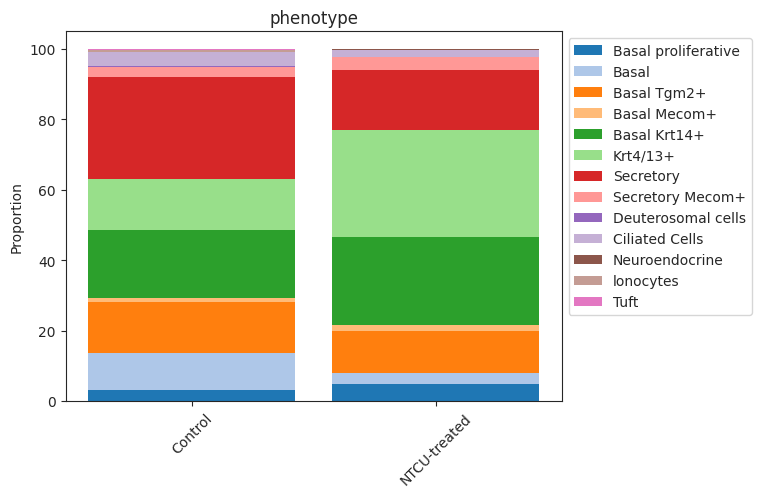

In [5]:
# Explore the data
# Stacked barplot for each patient
viz.stacked_barplot(data_all, feature_name="patientID")
plt.savefig('stackedBarplotSamples.pdf')
plt.show()

viz.stacked_barplot(data_all, feature_name="phenotype")
plt.savefig('stackedBarplotPhenotype.pdf')
plt.show()


<Figure size 1200x500 with 0 Axes>

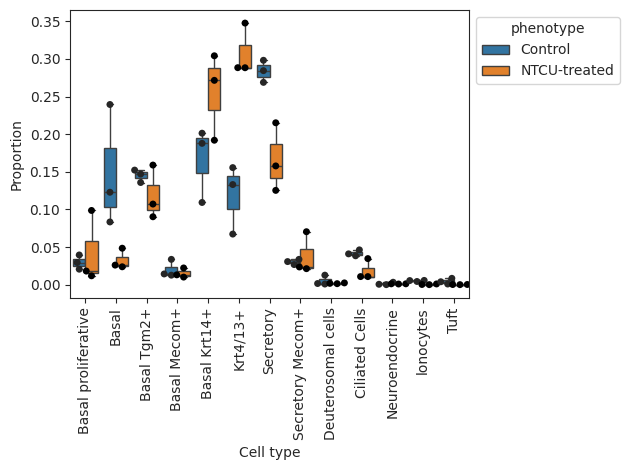

In [6]:
# Grouped boxplots. No facets, relative abundance, no dots.

fig = plt.figure(figsize=(12, 5))

viz.boxplots(
    data_all,
    feature_name="phenotype",
    plot_facets=False,
    y_scale="relative",
    add_dots=True,
    cmap="tab10"
)
plt.savefig('groupedBoxplotPhenotype_15W.pdf', dpi=fig.dpi)

plt.show()


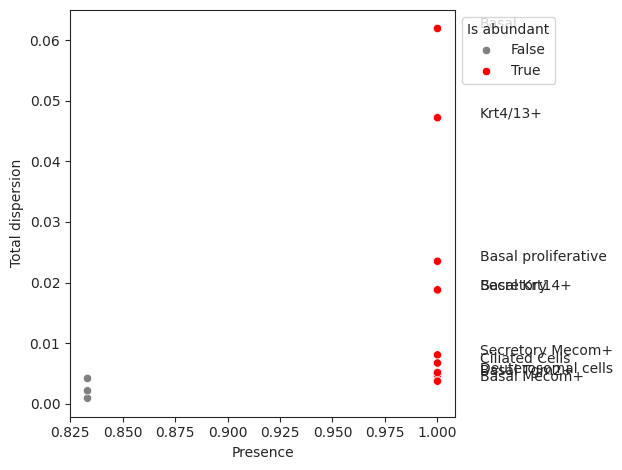

<Figure size 640x480 with 0 Axes>

In [7]:
viz.rel_abundance_dispersion_plot(
    data=data_all,
    abundant_threshold=0.9
)
plt.show()

plt.savefig('Total_dispersion.pdf')

In [8]:
# ref group
model_pheno = mod.CompositionalAnalysis(data_all,
                                         formula="phenotype",
                                         reference_cell_type="automatic")


model_pheno_res = model_pheno.sample_hmc()

Automatic reference selection! Reference cell type set to Basal Mecom+
Zero counts encountered in data! Added a pseudocount of 0.5.


2025-04-02 01:33:51.054290: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f30c0023940 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-02 01:33:51.054392: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
  0%|                                                 | 0/20000 [00:00<?, ?it/s]2025-04-02 01:33:51.184838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743554032.114360   42387 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-02 01:33:52.141857: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
100%|█████████████████████████████████████| 20000/20000 [06:19<00:00, 52.69it/s]


MCMC sampling finished. (477.034 sec)
Acceptance rate: 56.3%


In [9]:
model_pheno_res.summary()
print(model_pheno_res.credible_effects())

Compositional Analysis summary:

Data: 6 samples, 13 cell types
Reference index: 3
Formula: phenotype

Intercepts:
                     Final Parameter  Expected Sample
Cell Type                                            
Basal proliferative            1.249       162.101528
Basal                          2.567       605.601911
Basal Tgm2+                    2.724       708.551580
Basal Mecom+                   0.780       101.415187
Basal Krt14+                   2.926       867.159439
Krt4/13+                       2.599       625.294574
Secretory                      3.359      1337.052519
Secretory Mecom+               1.311       172.469922
Deuterosomal cells            -0.577        26.107506
Ciliated Cells                 1.342       177.900225
Neuroendocrine                -0.818        20.516365
lonocytes                     -0.614        25.159180
Tuft                          -0.899        18.920062


Effects:
                                               Final Parameter  